#**Recurrent Neural Net**

##**Set Up**

###**Imports & Device Setup**

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, "| GPU:", torch.cuda.get_device_name(0))

Device: cuda | GPU: NVIDIA A100-SXM4-80GB


In [2]:
X_train = torch.tensor(pd.read_csv("X_train.csv").values, dtype=torch.float32)
X_test  = torch.tensor(pd.read_csv("X_test.csv").values,  dtype=torch.float32)
y_train = torch.tensor(pd.read_csv("y_train.csv").values, dtype=torch.float32)
y_test  = torch.tensor(pd.read_csv("y_test.csv").values,  dtype=torch.float32)

X_train = X_train.reshape(-1, 400, 1)
X_test  = X_test.reshape(-1, 400, 1)

batch_size = 128
train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

##**Model Definition**

In [3]:
class VolRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=3):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        last = out[:, -1, :]
        return self.fc(last)

##**Training Function**

In [4]:
def train_model(model, train_dl, criterion, optimizer, epochs=100):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        running_loss = 0

        for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dl)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f}")

    return train_losses

##**Evaluation Function**

In [5]:
def evaluate_model(model, test_dl):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            logits = model(xb).cpu()
            all_logits.append(logits)
            all_labels.append(yb)

    all_logits = torch.cat(all_logits).squeeze()
    all_labels = torch.cat(all_labels).squeeze()

    probs = torch.sigmoid(all_logits)
    preds = (probs > 0.5).float()

    acc = accuracy_score(all_labels, preds)
    auc_score = roc_auc_score(all_labels, probs)

    return acc, auc_score, preds, probs, all_labels

##**Plots**

In [6]:
def plot_loss(losses):
    plt.figure(figsize=(7,4))
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

def plot_roc(labels, probs):
    fpr, tpr, _ = roc_curve(labels.cpu().numpy(), probs.cpu().numpy())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.legend()
    plt.show()

##**Confusion Matrix & Classification Report**

In [7]:
def diagnostics(labels, preds):
    cm = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Pred Down","Pred Up"],
                yticklabels=["True Down","True Up"])
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(labels.cpu().numpy(),
                                preds.cpu().numpy(),
                                target_names=["Vol Down","Vol Up"]))

##**Training & Evaluation**

###**Untuned Performance**

Epoch 1/100 | Loss: 0.6858


Epoch 2/100 | Loss: 0.6855


Epoch 3/100 | Loss: 0.6854


Epoch 4/100 | Loss: 0.6854


Epoch 5/100 | Loss: 0.6853


Epoch 6/100 | Loss: 0.6853


Epoch 7/100 | Loss: 0.6853


Epoch 8/100 | Loss: 0.6853


Epoch 9/100 | Loss: 0.6852


Epoch 10/100 | Loss: 0.6854


Epoch 11/100 | Loss: 0.6852


Epoch 12/100 | Loss: 0.6853


Epoch 13/100 | Loss: 0.6852


Epoch 14/100 | Loss: 0.6851


Epoch 15/100 | Loss: 0.6851


Epoch 16/100 | Loss: 0.6852


Epoch 17/100 | Loss: 0.6851


Epoch 18/100 | Loss: 0.6852


Epoch 19/100 | Loss: 0.6851


Epoch 20/100 | Loss: 0.6851


Epoch 21/100 | Loss: 0.6852


Epoch 22/100 | Loss: 0.6851


Epoch 23/100 | Loss: 0.6852


Epoch 24/100 | Loss: 0.6851


Epoch 25/100 | Loss: 0.6851


Epoch 26/100 | Loss: 0.6851


Epoch 27/100 | Loss: 0.6851


Epoch 28/100 | Loss: 0.6851


Epoch 29/100 | Loss: 0.6851


Epoch 30/100 | Loss: 0.6850


Epoch 31/100 | Loss: 0.6851


Epoch 32/100 | Loss: 0.6851


Epoch 33/100 | Loss: 0.6851


Epoch 34/100 | Loss: 0.6850


Epoch 35/100 | Loss: 0.6851


Epoch 36/100 | Loss: 0.6851


Epoch 37/100 | Loss: 0.6850


Epoch 38/100 | Loss: 0.6851


Epoch 39/100 | Loss: 0.6850


Epoch 40/100 | Loss: 0.6850


Epoch 41/100 | Loss: 0.6851


Epoch 42/100 | Loss: 0.6851


Epoch 43/100 | Loss: 0.6851


Epoch 44/100 | Loss: 0.6850


Epoch 45/100 | Loss: 0.6849


Epoch 46/100 | Loss: 0.6850


Epoch 47/100 | Loss: 0.6851


Epoch 48/100 | Loss: 0.6850


Epoch 49/100 | Loss: 0.6850


Epoch 50/100 | Loss: 0.6849


Epoch 51/100 | Loss: 0.6850


Epoch 52/100 | Loss: 0.6850


Epoch 53/100 | Loss: 0.6850


Epoch 54/100 | Loss: 0.6850


Epoch 55/100 | Loss: 0.6850


Epoch 56/100 | Loss: 0.6849


Epoch 57/100 | Loss: 0.6850


Epoch 58/100 | Loss: 0.6850


Epoch 59/100 | Loss: 0.6849


Epoch 60/100 | Loss: 0.6849


Epoch 61/100 | Loss: 0.6850


Epoch 62/100 | Loss: 0.6849


Epoch 63/100 | Loss: 0.6850


Epoch 64/100 | Loss: 0.6849


Epoch 65/100 | Loss: 0.6849


Epoch 66/100 | Loss: 0.6849


Epoch 67/100 | Loss: 0.6849


Epoch 68/100 | Loss: 0.6849


Epoch 69/100 | Loss: 0.6849


Epoch 70/100 | Loss: 0.6849


Epoch 71/100 | Loss: 0.6849


Epoch 72/100 | Loss: 0.6849


Epoch 73/100 | Loss: 0.6849


Epoch 74/100 | Loss: 0.6849


Epoch 75/100 | Loss: 0.6848


Epoch 76/100 | Loss: 0.6848


Epoch 77/100 | Loss: 0.6848


Epoch 78/100 | Loss: 0.6848


Epoch 79/100 | Loss: 0.6848


Epoch 80/100 | Loss: 0.6849


Epoch 81/100 | Loss: 0.6848


Epoch 82/100 | Loss: 0.6848


Epoch 83/100 | Loss: 0.6849


Epoch 84/100 | Loss: 0.6849


Epoch 85/100 | Loss: 0.6847


Epoch 86/100 | Loss: 0.6866


Epoch 87/100 | Loss: 0.6879


Epoch 88/100 | Loss: 0.6870


Epoch 89/100 | Loss: 0.6863


Epoch 90/100 | Loss: 0.6866


Epoch 91/100 | Loss: 0.6863


Epoch 92/100 | Loss: 0.6860


Epoch 93/100 | Loss: 0.6858


Epoch 94/100 | Loss: 0.6857


Epoch 95/100 | Loss: 0.6858


Epoch 96/100 | Loss: 0.6858


Epoch 97/100 | Loss: 0.6855


Epoch 98/100 | Loss: 0.6855


Epoch 99/100 | Loss: 0.6852


Epoch 100/100 | Loss: 0.6854


Final Test Accuracy: 0.5525
Final Test AUC:      0.5750



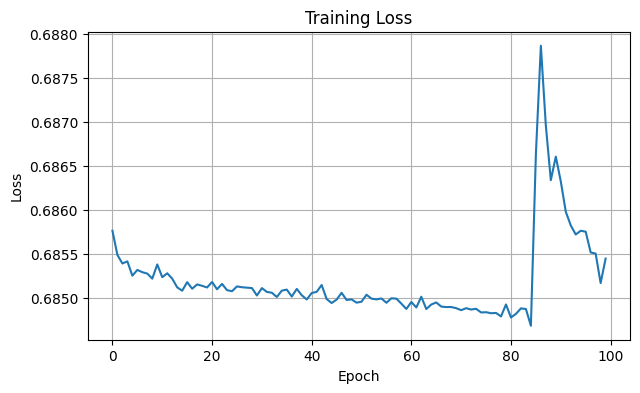

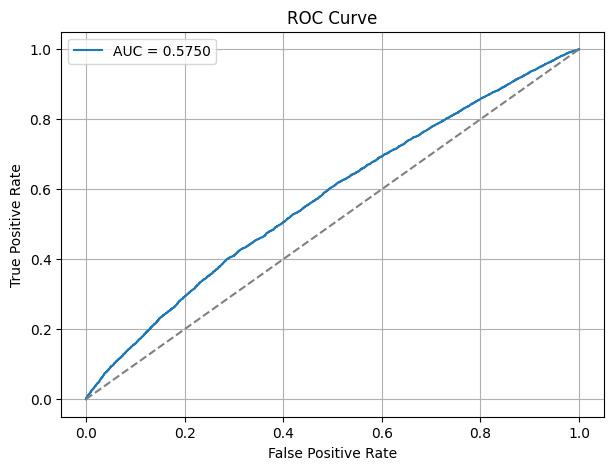

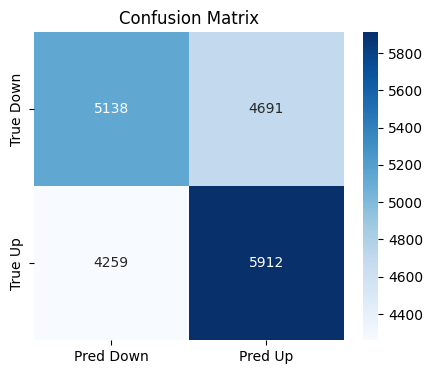


Classification Report:
              precision    recall  f1-score   support

    Vol Down       0.55      0.52      0.53      9829
      Vol Up       0.56      0.58      0.57     10171

    accuracy                           0.55     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.55      0.55      0.55     20000



In [8]:
model = VolRNN(hidden_size=32, num_layers=3).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = train_model(model, train_dl, criterion, optimizer, epochs=100)

acc, auc_score, preds, probs, labels = evaluate_model(model, test_dl)

print("")
print(f"\nFinal Test Accuracy: {acc:.4f}")
print(f"Final Test AUC:      {auc_score:.4f}")

print("")
plot_loss(losses)
print("")
plot_roc(labels, probs)
print("")
diagnostics(labels, preds)

##**Hyperparameter Tuning**

In [9]:
def train_model_quiet(model, train_dl, criterion, optimizer, epochs=10):
    model.train()
    for _ in range(epochs):
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

In [10]:
def evaluate_auc(model, test_dl):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            logits = model(xb).cpu()
            all_logits.append(logits)
            all_labels.append(yb)

    all_logits = torch.cat(all_logits).squeeze()
    all_labels = torch.cat(all_labels).squeeze()

    probs = torch.sigmoid(all_logits)
    auc_score = roc_auc_score(all_labels, probs)
    acc = accuracy_score(all_labels, (probs > 0.5).float())

    return auc_score, acc

In [11]:
from itertools import product
import pandas as pd

search_space = {
    "hidden_size": [16, 32, 64],
    "num_layers": [1, 2, 3],
    "lr": [1e-3, 5e-4],
    "dropout": [0.0, 0.2]
}

def build_model(hidden_size, num_layers, dropout):
    class VolRNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.rnn = nn.RNN(
                input_size=1,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
            self.fc = nn.Linear(hidden_size, 1)

        def forward(self, x):
            out, _ = self.rnn(x)
            return self.fc(out[:, -1, :])

    return VolRNN().to(device)

def clean_grid_search(search_space):
    keys, values = zip(*search_space.items())
    configs = [dict(zip(keys, v)) for v in product(*values)]

    results = []

    for cfg in configs:
        model = build_model(cfg["hidden_size"], cfg["num_layers"], cfg["dropout"])
        optimizer = optim.Adam(model.parameters(), lr=cfg["lr"])
        criterion = nn.BCEWithLogitsLoss()

        # quiet training
        train_model_quiet(model, train_dl, criterion, optimizer, epochs=10)

        auc_score, acc_score = evaluate_auc(model, test_dl)

        results.append({
            "hidden_size": cfg["hidden_size"],
            "num_layers": cfg["num_layers"],
            "dropout": cfg["dropout"],
            "lr": cfg["lr"],
            "AUC": auc_score,
            "Accuracy": acc_score
        })

    return pd.DataFrame(results).sort_values(by="AUC", ascending=False)

In [12]:
df_results = clean_grid_search(search_space)
df_results

,hidden_size,num_layers,dropout,lr,AUC,Accuracy
20,32,3,0.0,0.0010,0.576289,0.55145
33,64,3,0.2,0.0010,0.576275,0.55275
22,32,3,0.0,0.0005,0.576245,0.55145
6,16,2,0.0,0.0005,0.575820,0.55405
2,16,1,0.0,0.0005,0.575768,0.55440
16,32,2,0.0,0.0010,0.575762,0.55280
18,32,2,0.0,0.0005,0.575651,0.55285
19,32,2,0.2,0.0005,0.575643,0.55185
7,16,2,0.2,0.0005,0.575638,0.55260
28,64,2,0.0,0.0010,0.575609,0.55215


In [13]:
top5 = df_results.head(5).reset_index(drop=True)
print(" Top 5 Hyperparameter Configurations (Ranked by AUC):")
top5

 Top 5 Hyperparameter Configurations (Ranked by AUC):


,hidden_size,num_layers,dropout,lr,AUC,Accuracy
0,32,3,0.0,0.0010,0.576289,0.55145
1,64,3,0.2,0.0010,0.576275,0.55275
2,32,3,0.0,0.0005,0.576245,0.55145
3,16,2,0.0,0.0005,0.575820,0.55405
4,16,1,0.0,0.0005,0.575768,0.55440


###**Tuned Performance**

In [19]:
best_row = df_results.iloc[0]
print(
    f"""
Summary of Hyperparameter Search:
- Best AUC achieved: {best_row['AUC']:.4f}
- Corresponding accuracy: {best_row['Accuracy']:.4f}
- Best configuration:
    hidden_size = {best_row['hidden_size']}
    num_layers  = {best_row['num_layers']}
    dropout     = {best_row['dropout']}
    learning_rate = {best_row['lr']}
"""
)


Summary of Hyperparameter Search:
- Best AUC achieved: 0.5763
- Corresponding accuracy: 0.5514
- Best configuration:
    hidden_size = 32.0
    num_layers  = 3.0
    dropout     = 0.0
    learning_rate = 0.001

